In [1]:
from Frames_new import *
from Utility import *
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings("ignore")
from keras.utils.io_utils import HDF5Matrix
import random
import matplotlib.pyplot as plt
BATCH_SIZE = 32
epochs = 60
weights_name = '1OCT_Seg_UNet.hdf5'
from __future__ import print_function
import numpy as np
import os
import sys
from copy import deepcopy
import csv
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.models import Model
from keras.utils.io_utils import HDF5Matrix
from keras.layers import Permute, Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Dropout,Activation,Dense,Flatten, Lambda, PReLU, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import tensorflow as tf
from scipy.io import loadmat,savemat
img_rows = 128
img_cols = 128
BATCH_SIZE = 32

Using TensorFlow backend.


# PART 1. Labeling the Maxillary Sinus

In [21]:
model = UNet().get_unet()
if os.path.isfile(weights_name):
    model.load_weights(weights_name)
    #Adam(lr=1e-4)
model.compile(optimizer='sgd', loss='mean_squared_error',metrics=[dice_coef,'acc'])
Xt = './data/X_train_CT_sinus_binary_128.h5'
Yt = './data/X_train_CT_sinus_binary_128.h5'
X_train = HDF5Matrix(Xt, 'DSx')
Y_train = HDF5Matrix(Yt, 'DSy')
print (Y_train.shape)
print (X_train.shape)
X_train = np.transpose(X_train, (2,1,0))[60:]
Y_train = np.transpose(Y_train, (2,1,0))[60:]
def train_and_predict():
    history = []
    print('Creating and compiling model...')
    print('-'*30)
    #plt.imshow(Y_train[:,:,50])
    #plt.show()
    for epoch in range(epochs):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        nums = [x for x in range(X_train.shape[0])]
        random.shuffle(nums)
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            # extract training batch
            trainIdx = nums[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            trainIdx.sort()
            X_batch = X_train[trainIdx]
            X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
            mean = np.mean(X_batch)  # mean for data centering
            std = np.std(X_batch)  # std for data normalization
            #plt.imshow(X_batch[0,0,:,:])
            Y_batch = Y_train[trainIdx].reshape(X_batch.shape[0],1,img_rows,img_cols)
            X_batch -= mean
            X_batch /= std
            # plt.imshow(X_batch[0,0,:,:])
            # plt.show()
            print ('indexNew')
            X_batch = X_batch.transpose((0,2,3,1))
            Y_batch = Y_batch.transpose((0,2,3,1))
            plt.imshow(Y_batch[0,:,:,0].reshape(128,128),cmap = 'Greys')
            plt.colorbar()
            plt.show()
            loss = model.train_on_batch(X_batch, Y_batch)
            print("batch %d loss : %f dice : %f" % (index, loss[0], loss[1]))
            YY = model.predict(X_batch[:1], batch_size=None, verbose=0, steps=None)
            print(YY.shape)
            plt.imshow(YY[0,:,:,0].reshape(128,128),cmap = 'Greys')
            plt.colorbar()
            plt.show()
        history= [loss]
        print("saving results")
        with open(loss_name, "a") as f:
            writer = csv.writer(f)
            writer.writerows(history)
        model.save_weights(weights_name)

    return history

ValueError: You are trying to load a weight file containing 37 layers into a model with 21 layers.

In [14]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    print ("intersection is, ", intersection)
    print ('NEED FOR CHECK, ', y_true_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [15]:
def conv_block(x,nb_filters,filter_size=(3,3),initial ='he_normal', bmode='same'):
    conv = Conv2D(nb_filters, filter_size,activation='relu', kernel_initializer=initial, padding=bmode)(x)
    conv = BatchNormalization(axis=-1)(conv)
    conv = Conv2D(nb_filters, filter_size, activation='relu', kernel_initializer=initial, padding=bmode)(conv)
    conv = BatchNormalization(axis=-1)(conv)
    return conv
def downconv_block(x,nb_filters,filter_size=(3,3),drate = 0.2,initial ='he_normal', bmode='same', poolsize=(2,2)):
    conv_in = conv_block(x,nb_filters,filter_size,initial,bmode)
    conv_out = MaxPooling2D(pool_size=poolsize)(conv_in)
    #conv_out = Dropout(drate)(conv_out)
    return conv_in,conv_out
def upconv_block(x_down,x,nb_filters,filter_size=(3,3),drate = 0.2,initial ='he_normal', bmode='same', poolsize=(2,2)):
    #x_down = Dropout(drate)(x_down)
    conv = concatenate([UpSampling2D(poolsize)(x_down), x])
    conv_out = conv_block(conv,nb_filters,filter_size,initial,bmode)
    return conv_out

# A shallow net

In [16]:
class UNet(object):
    def __init__(self,img_rows = img_rows,img_cols = img_cols,input_channel = 1,output_channel=1,\
                 initial_filter = 32,act = 'relu',drate = 0.2, filter_size = (5,5), \
                 initial = 'he_normal', bmode='same',poolsize=(2,2)):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.nb_filter = initial_filter
        self.act = act
        self.initial_filter = initial_filter
        self.drate = drate
        self.filter_size = filter_size
        self.initial = initial
        self.bmode = bmode
        self.poolsize = poolsize
    def get_unet(self):
        # single U-Net
        inputs = Input(shape = (self.img_rows, self.img_cols,self.input_channel))
        nb_filters = self.nb_filter
        # Full self.params are not delivered! All default settings
        # Encoder
        conv1,conv1_down = downconv_block(inputs,nb_filters,drate=self.drate)
        conv2,conv2_down = downconv_block(conv1_down,nb_filters*2,drate=self.drate)
        # conv3,conv3_down = downconv_block(conv2_down,nb_filters*4,drate=self.drate)
        # conv4,conv4_down = downconv_block(conv3_down,nb_filters*8,drate=self.drate)
        # conv5 = conv_block(conv4_down,nb_filters*16)
        conv3 = conv_block(conv2_down,nb_filters*4)
        # Decoder
        # up4 = upconv_block(conv5,conv4,nb_filters*8,drate=self.drate)
        # up3 = upconv_block(up4,conv3,nb_filters*4,drate=self.drate)
        up2 = upconv_block(conv3,conv2,nb_filters*2,drate=self.drate)
        up1 = upconv_block(up2,conv1,nb_filters,drate=self.drate)
        # up1 = Dropout(self.drate)(up1)
        conv_out = Conv2D(self.output_channel, (1, 1),activation=self.act)(up1)
        unet = Model(input=inputs, output=[conv_out])
        return unet
#     def get_unet_dpath(self):
#         # Dual path U-Net, Additional path for lesion mask
#         inputs = Input(shape = (self.img_rows, self.img_cols,self.input_channel))
#         nb_filters = self.nb_filter
#         conv1,conv1_down = downconv_block(inputs,nb_filters,drate=self.drate)
#         conv2,conv2_down = downconv_block(conv1_down,nb_filters*2,drate=self.drate)
#         conv3,conv3_down = downconv_block(conv2_down,nb_filters*4,drate=self.drate)
#         conv4,conv4_down = downconv_block(conv3_down,nb_filters*8,drate=self.drate)
#         conv5 = conv_block(conv4_down,nb_filters*16)
#         up4 = upconv_block(conv5,conv4,nb_filters*8,drate=self.drate)
#         up3 = upconv_block(up4,conv3,nb_filters*8,drate=self.drate)
#         up3_1 = upconv_block(up4,conv3,nb_filters*4,drate=self.drate)
#         up3_2 = upconv_block(up4,conv3,nb_filters*4,drate=self.drate)
#         up2_1 = upconv_block(up3_1,conv2,nb_filters*2,drate=self.drate)
#         up2_2 = upconv_block(up3_2,conv2,nb_filters*2,drate=self.drate)
#         up1_1 = upconv_block(up2_1,conv1,nb_filters,drate=self.drate)
#         up1_2 = upconv_block(up2_2,conv1,nb_filters,drate=self.drate)
#         # First channel for layer masks
#         up1_1 = Dropout(self.drate)(up1_1)
#         conv_out1 = Conv2D(self.output_channel, (1, 1),activation='softmax')(up1_1)
#         # Second channel for lesions
#         up1_2 = Dropout(self.drate)(up1_2)
#         conv_out2 = Conv2D(1, (1, 1),activation='sigmoid')(up1_2)
#         unet = Model(input=inputs, output=[conv_out1,conv_out2])
#         return unet

Creating and compiling model...
------------------------------
Epoch is 0
Number of batches 14
indexNew


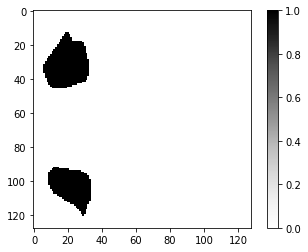

batch 0 loss : 0.939130 dice : 0.075602
(1, 128, 128, 1)


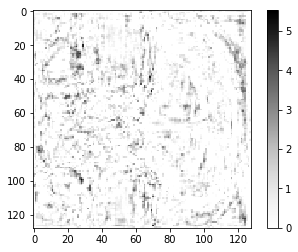

indexNew


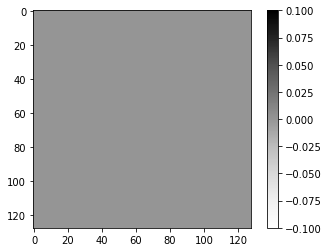

batch 1 loss : 0.627671 dice : 0.126896
(1, 128, 128, 1)


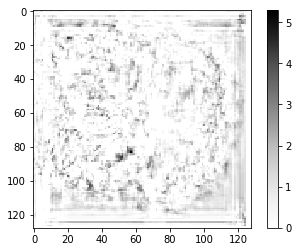

indexNew


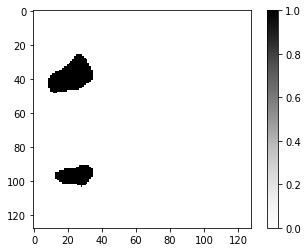

batch 2 loss : 0.534570 dice : 0.122061
(1, 128, 128, 1)


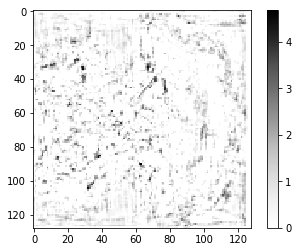

indexNew


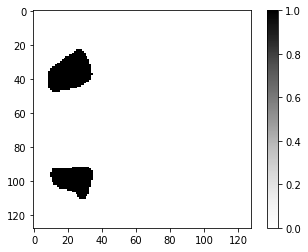

batch 3 loss : 0.464590 dice : 0.081954
(1, 128, 128, 1)


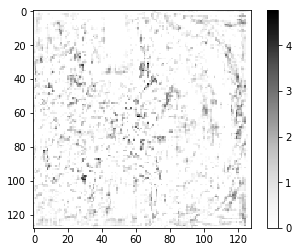

indexNew


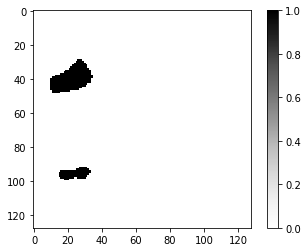

batch 4 loss : 0.404054 dice : 0.134450
(1, 128, 128, 1)


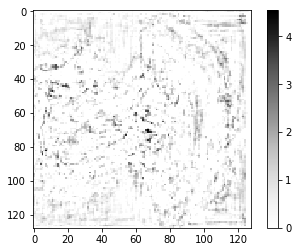

indexNew


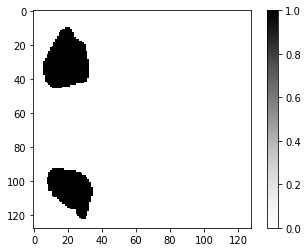

batch 5 loss : 0.348643 dice : 0.096191
(1, 128, 128, 1)


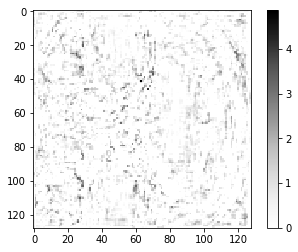

indexNew


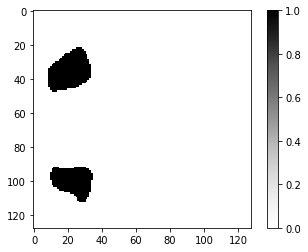

batch 6 loss : 0.315678 dice : 0.121415
(1, 128, 128, 1)


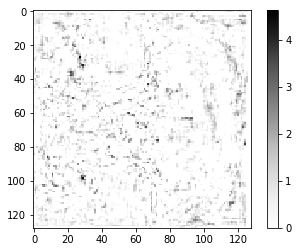

indexNew


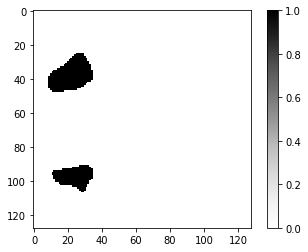

batch 7 loss : 0.280334 dice : 0.131413
(1, 128, 128, 1)


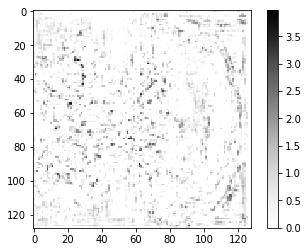

indexNew


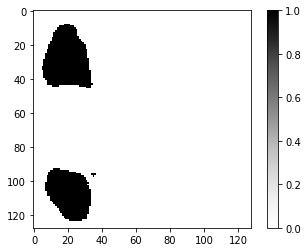

batch 8 loss : 0.263232 dice : 0.145074
(1, 128, 128, 1)


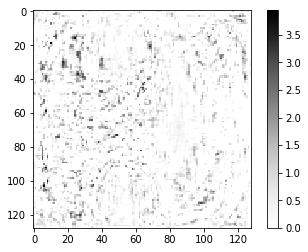

indexNew


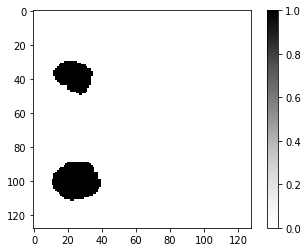

batch 9 loss : 0.230294 dice : 0.120990
(1, 128, 128, 1)


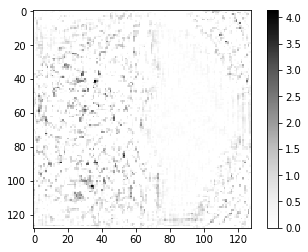

indexNew


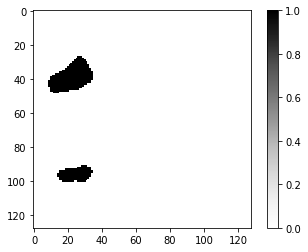

batch 10 loss : 0.224053 dice : 0.129563
(1, 128, 128, 1)


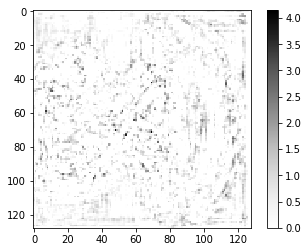

indexNew


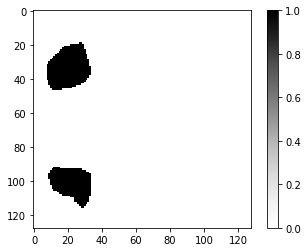

batch 11 loss : 0.203089 dice : 0.128686
(1, 128, 128, 1)


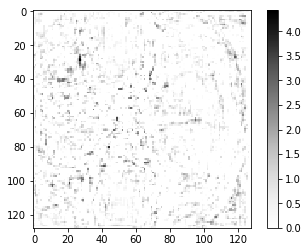

indexNew


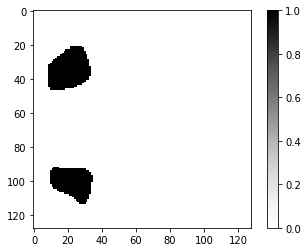

batch 12 loss : 0.190713 dice : 0.135339
(1, 128, 128, 1)


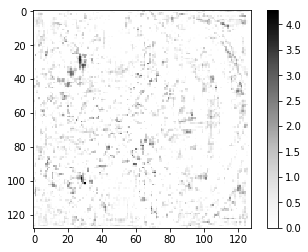

indexNew


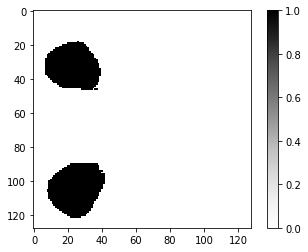

batch 13 loss : 0.183373 dice : 0.172565
(1, 128, 128, 1)


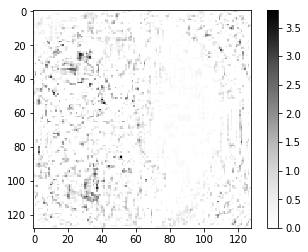

saving results


FileNotFoundError: [Errno 2] No such file or directory: './Traininghistory/loss_UNet.csv'

In [27]:
train_and_predict()

In [23]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(len(weights))

0
2
4
2
4
0
2
4
2
4
0
2
4
2
4
0
0
2
4
2
4
0
0
2
4
2
4
2


In [19]:
print(model.summary)

<bound method Container.summary of <keras.engine.training.Model object at 0x1833054160>>


In [81]:
weights_name = '1OCT_Seg_UNet.hdf5'
model = UNet().get_unet()
if os.path.isfile(weights_name):
    model.load_weights(weights_name)
model.compile(optimizer=Adam(lr=1e-4), loss=binary_crossentropy,metrics=[dice_coef])

ValueError: You are trying to load a weight file containing 37 layers into a model with 21 layers.

(10, 128, 128, 1)


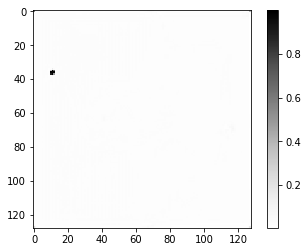

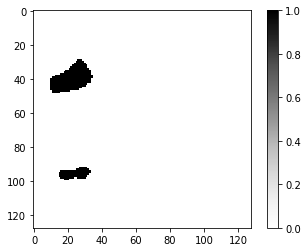

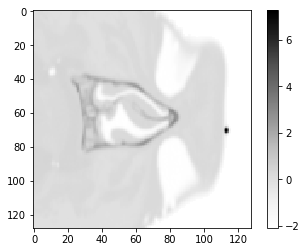

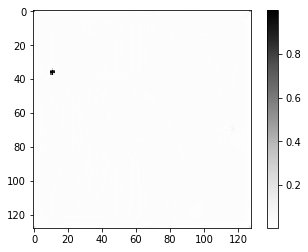

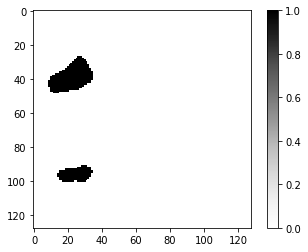

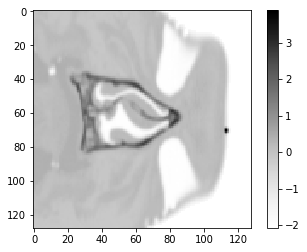

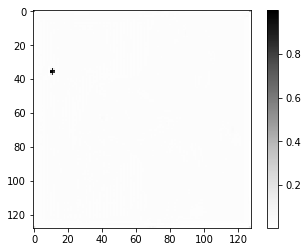

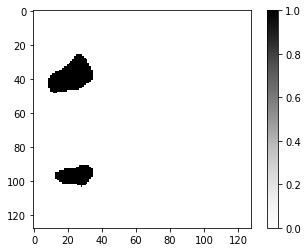

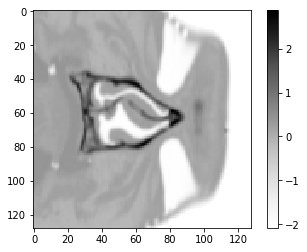

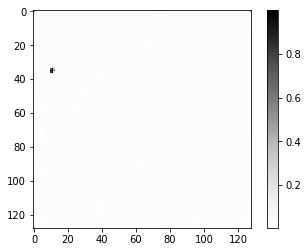

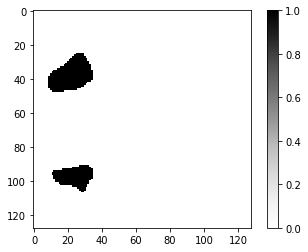

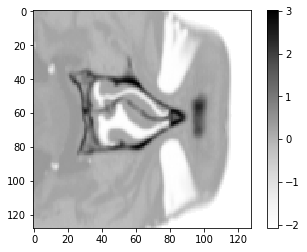

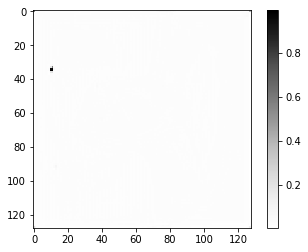

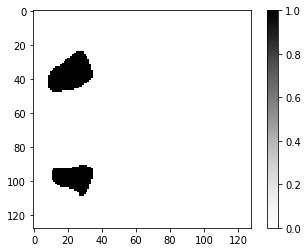

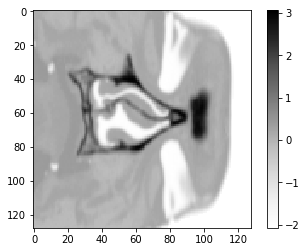

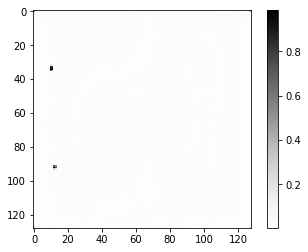

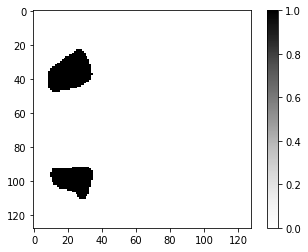

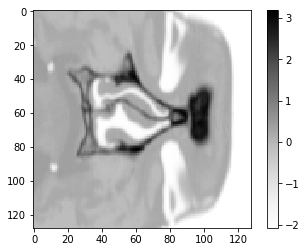

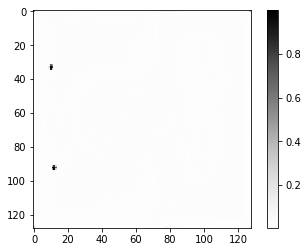

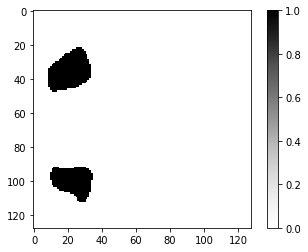

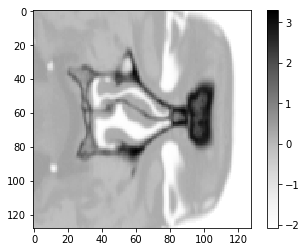

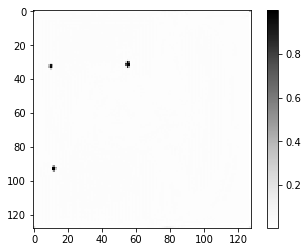

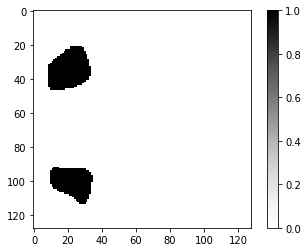

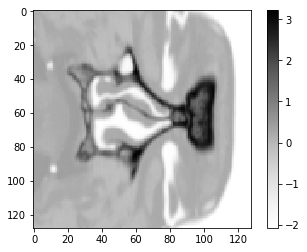

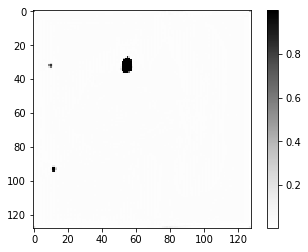

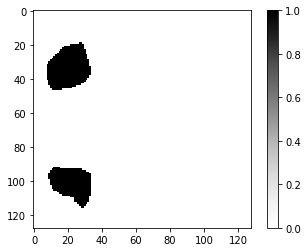

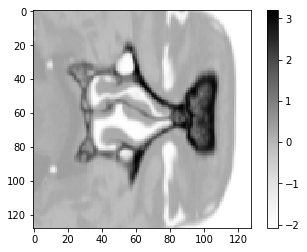

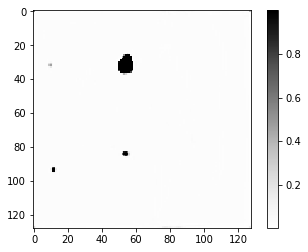

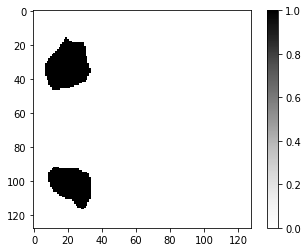

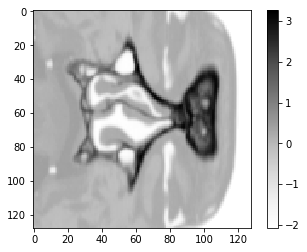

In [63]:
#Xt = './data/X_train_CT_sinus_binary_128.h5'
Xt = './data/X_train_CT_sinusTest_128.h5'
Yt = './data/X_train_CT_sinus_binary_128.h5'
X_train = HDF5Matrix(Xt, 'DSt')
Y_train = HDF5Matrix(Yt, 'DSy')
X_train = np.transpose(X_train, (2,1,0))[60:]
Y_train = np.transpose(Y_train, (2,1,0))[60:]
X_batch = X_train
Y_batch = Y_train
X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
mean = np.mean(X_batch)  # mean for data centering
std = np.std(X_batch)  # std for data normalization
X_batch -= mean
X_batch /= std
X_batch = X_batch.transpose((0,2,3,1))
YY = model.predict(X_batch[:10], batch_size=1, verbose=0)
print(YY.shape)
count = 0
for yy in YY:
    plt.imshow
    plt.imshow(yy[:,:,0].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    
    plt.imshow(Y_batch[count,:,:].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    count = count +1
    plt.imshow(X_batch[count,:,:].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
# plt.imshow(YY[0,:,:,0].reshape(128,128),cmap = 'Greys')
# plt.colorbar()
# plt.show()
# plt.imshow(Y_batch[0,:,:].reshape(128,128),cmap = 'Greys')
# plt.colorbar()
# plt.show()

In [85]:
def quantization(YY, thre):
    mask = YY > thre
    YY[mask] = 1
    YY[~mask] = 0
    return YY

In [82]:
class UNett(object):
    def __init__(self,img_rows = img_rows,img_cols = img_cols,input_channel = 1,output_channel=1,\
                 initial_filter = 32,act = 'sigmoid',drate = 0.2, filter_size = (3,3), \
                 initial = 'he_normal', bmode='same',poolsize=(2,2)):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.nb_filter = initial_filter
        self.act = act
        self.initial_filter = initial_filter
        self.drate = drate
        self.filter_size = filter_size
        self.initial = initial
        self.bmode = bmode
        self.poolsize = poolsize
    def get_unet(self):
        # single U-Net
        inputs = Input(shape = (self.img_rows, self.img_cols,self.input_channel))
        nb_filters = self.nb_filter
        # Full self.params are not delivered! All default settings
        # Encoder
        conv1,conv1_down = downconv_block(inputs,nb_filters,drate=self.drate)
        conv2,conv2_down = downconv_block(conv1_down,nb_filters*2,drate=self.drate)
        conv3,conv3_down = downconv_block(conv2_down,nb_filters*4,drate=self.drate)
        conv4,conv4_down = downconv_block(conv3_down,nb_filters*8,drate=self.drate)
        conv5 = conv_block(conv4_down,nb_filters*16)
        # Decoder
        up4 = upconv_block(conv5,conv4,nb_filters*8,drate=self.drate)
        up3 = upconv_block(up4,conv3,nb_filters*4,drate=self.drate)
        up2 = upconv_block(up3,conv2,nb_filters*2,drate=self.drate)
        up1 = upconv_block(up2,conv1,nb_filters,drate=self.drate)
        up1 = Dropout(self.drate)(up1)
        conv_out = Conv2D(self.output_channel, (1, 1),activation=self.act)(up1)
        unet = Model(input=inputs, output=[conv_out])
        return unet

In [84]:
weights_name = '1OCT_Seg_UNet.hdf5'
model = UNett().get_unet()
if os.path.isfile(weights_name):
    model.load_weights(weights_name)
model.compile(optimizer=Adam(lr=1e-4), loss=binary_crossentropy,metrics=[dice_coef])

intersection is,  Tensor("metrics_14/dice_coef/Sum:0", shape=(), dtype=float32)
NEED FOR CHECK,  Tensor("metrics_14/dice_coef/Reshape:0", shape=(?,), dtype=float32)


(60, 1, 128, 128)
(30, 128, 128, 1)


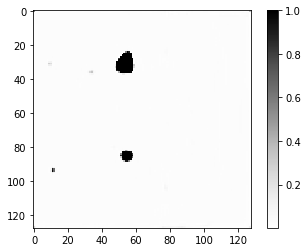

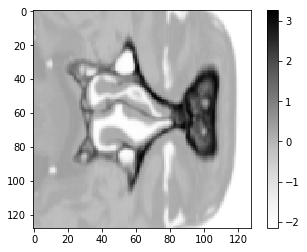

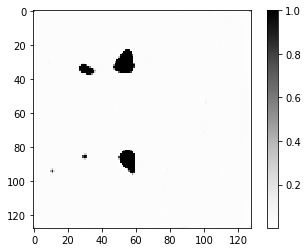

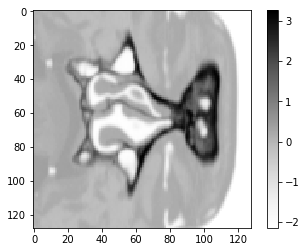

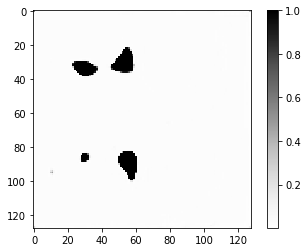

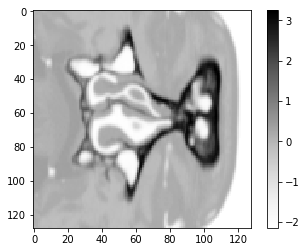

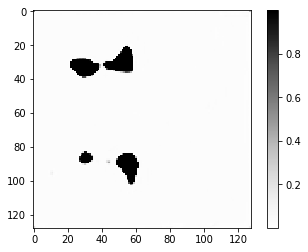

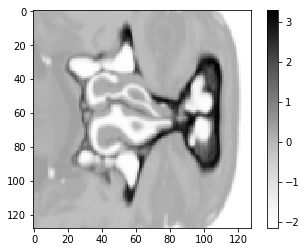

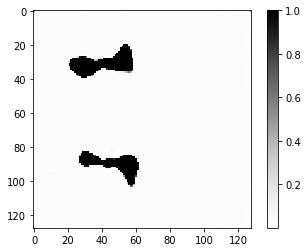

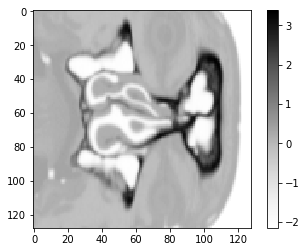

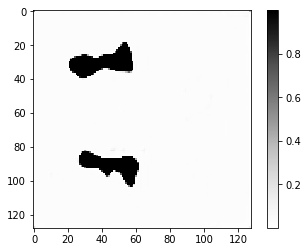

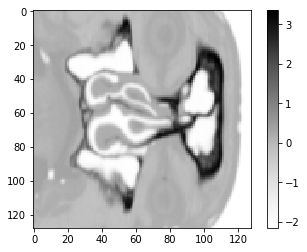

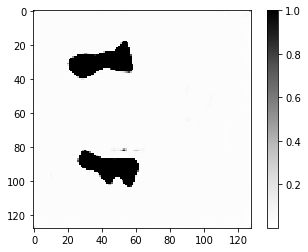

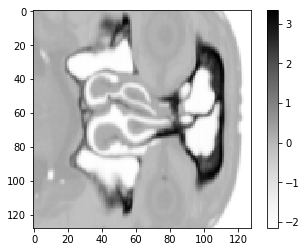

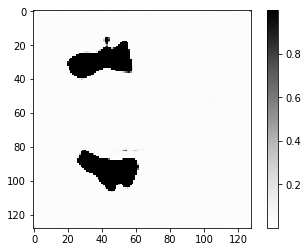

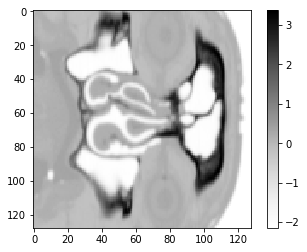

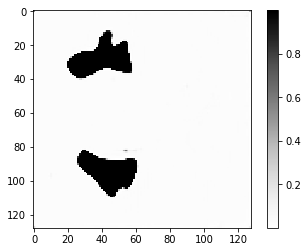

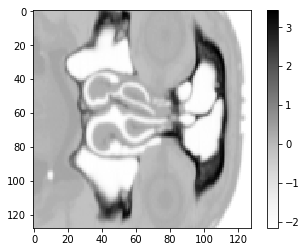

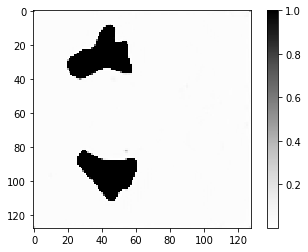

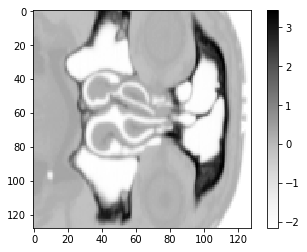

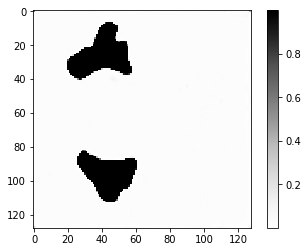

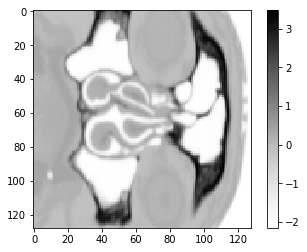

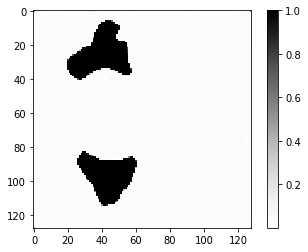

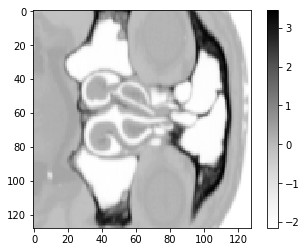

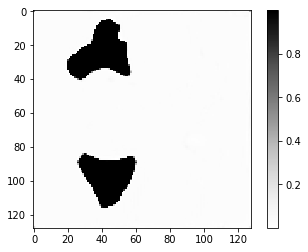

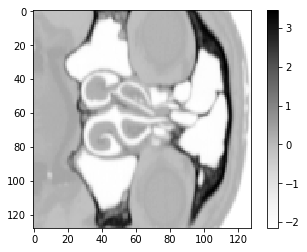

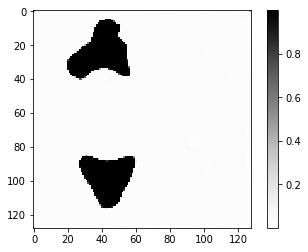

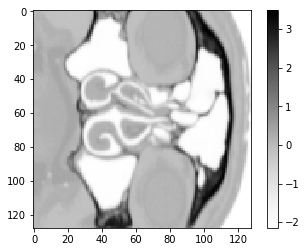

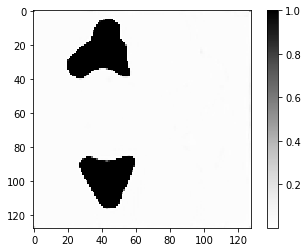

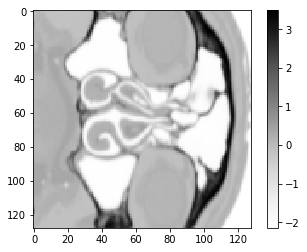

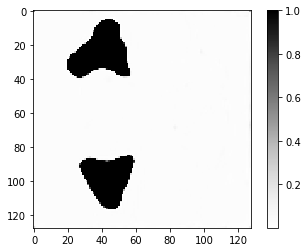

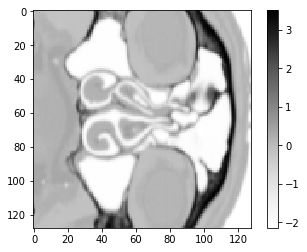

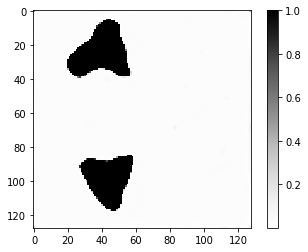

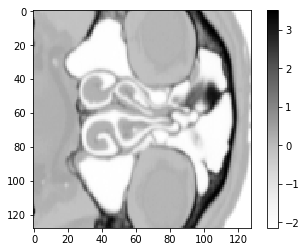

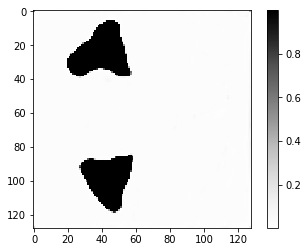

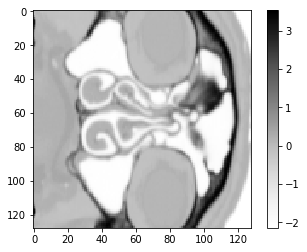

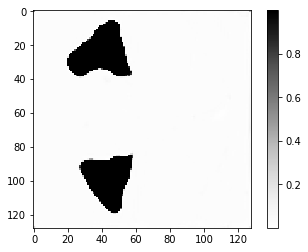

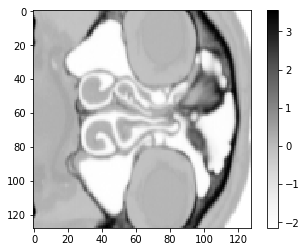

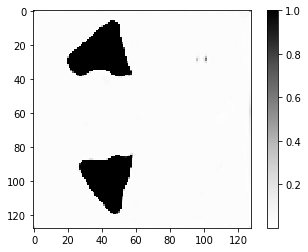

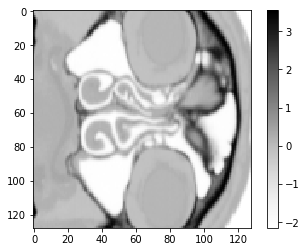

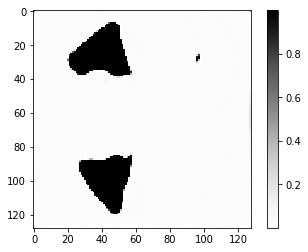

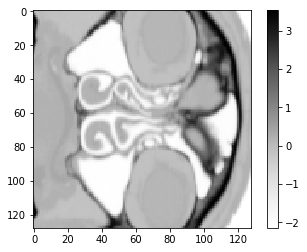

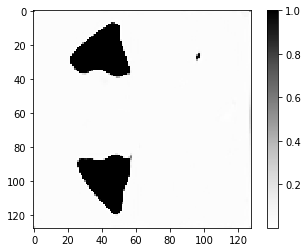

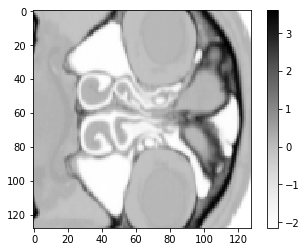

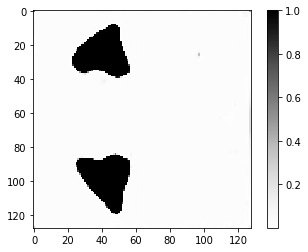

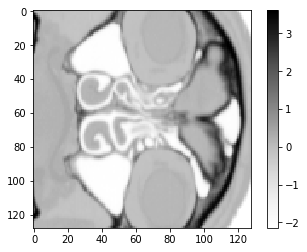

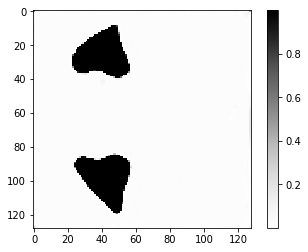

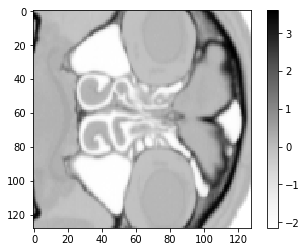

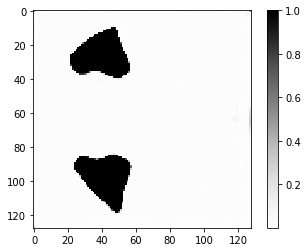

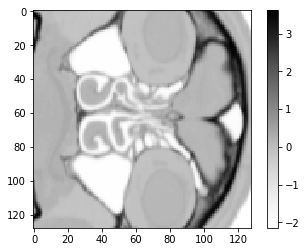

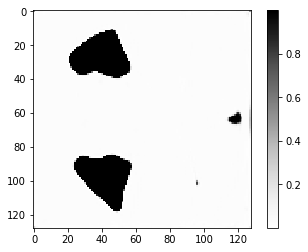

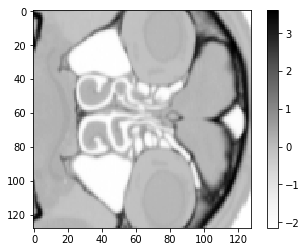

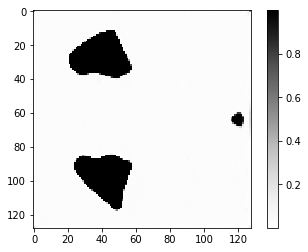

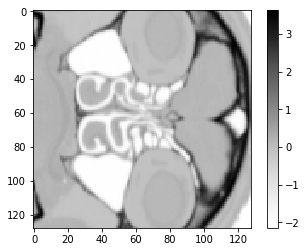

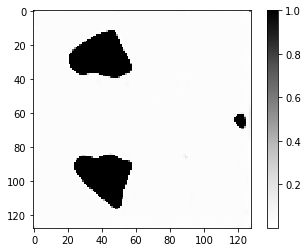

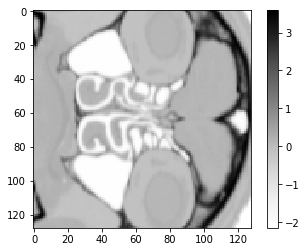

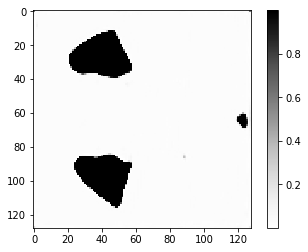

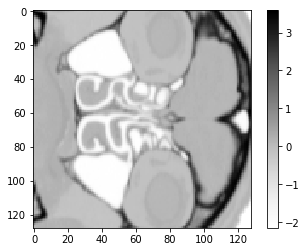

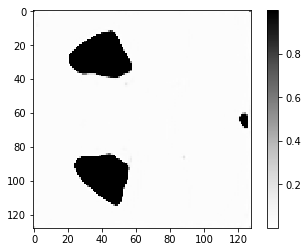

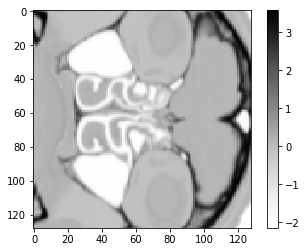

In [85]:
Xt = './data/X_train_CT_sinusTest_128.h5'
X_test = HDF5Matrix(Xt, 'DSt')
X_batch = np.transpose(X_test, (2,1,0))[70:]
X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
print (X_batch.shape)
mean = np.mean(X_batch)  # mean for data centering
std = np.std(X_batch)  # std for data normalization
X_batch -= mean
X_batch /= std
X_batch = X_batch.transpose((0,2,3,1))
YY = model.predict(X_batch[:30], batch_size=1, verbose=0)
print(YY.shape)
count = 0
for yy in YY:
    plt.imshow(yy[:,:,0].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    
    plt.imshow(X_batch[count,:,:].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    count = count +1

# PART 2. With multiple labels.

In [2]:
class UNet(object):
    def __init__(self,img_rows = img_rows,img_cols = img_cols,input_channel = 1,output_channel=5,\
                 initial_filter = 32,act = 'softmax',drate = 0.2, filter_size = (3,3), \
                 initial = 'he_normal', bmode='same',poolsize=(2,2)):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.nb_filter = initial_filter
        self.act = act
        self.initial_filter = initial_filter
        self.drate = drate
        self.filter_size = filter_size
        self.initial = initial
        self.bmode = bmode
        self.poolsize = poolsize
    def get_unet(self):
        # single U-Net
        inputs = Input(shape = (self.img_rows, self.img_cols,self.input_channel))
        nb_filters = self.nb_filter
        # Full self.params are not delivered! All default settings
        # Encoder
        conv1,conv1_down = downconv_block(inputs,nb_filters,drate=self.drate)
        conv2,conv2_down = downconv_block(conv1_down,nb_filters*2,drate=self.drate)
        conv3,conv3_down = downconv_block(conv2_down,nb_filters*4,drate=self.drate)
        conv4,conv4_down = downconv_block(conv3_down,nb_filters*8,drate=self.drate)
        conv5 = conv_block(conv4_down,nb_filters*16)
        # Decoder
        up4 = upconv_block(conv5,conv4,nb_filters*8,drate=self.drate)
        up3 = upconv_block(up4,conv3,nb_filters*4,drate=self.drate)
        up2 = upconv_block(up3,conv2,nb_filters*2,drate=self.drate)
        up1 = upconv_block(up2,conv1,nb_filters,drate=self.drate)
        up1 = Dropout(self.drate)(up1)
        conv_out = Conv2D(self.output_channel, (1, 1),activation=self.act)(up1)
        unet = Model(input=inputs, output=[conv_out])
        return unet
weights_name = 'categorical.hdf5'
model = UNet().get_unet()
if os.path.isfile(weights_name):
    model.load_weights(weights_name)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=[dice_coef])



intersection is,  Tensor("metrics/dice_coef/Sum:0", shape=(), dtype=float32)
NEED FOR CHECK,  Tensor("metrics/dice_coef/Reshape:0", shape=(?,), dtype=float32)


In [3]:

Xt = './data/X_train_CT_sinus_binary1_128.h5'
Yt = './data/X_train_CT_sinus_binary1_128.h5'
X_train = HDF5Matrix(Xt, 'DSx')
Y_train = HDF5Matrix(Yt, 'DSy')
print (Y_train.shape)
print (X_train.shape)
X_train = np.transpose(X_train, (2,1,0))
Y_train = np.transpose(Y_train, (2,1,0))
# def train_and_predict():
#     history = []
#     print('Creating and compiling model...')
#     print('-'*30) 
#     #plt.imshow(Y_train[:,:,50])
#     #plt.show()
#     for epoch in range(epochs):
#         print("Epoch is", epoch)
#         print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
#         nums = [x for x in range(X_train.shape[0])]
#         random.shuffle(nums)
#         for index in range(int(X_train.shape[0]/BATCH_SIZE)):
#             # extract training batch
#             trainIdx = nums[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
#             trainIdx.sort()
#             X_batch = X_train[trainIdx]
#             X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
#             mean = np.mean(X_batch)  # mean for data centering
#             std = np.std(X_batch)  # std for data normalization
#             Y_batch = Y_train[trainIdx].reshape(X_batch.shape[0],1,img_rows,img_cols)
#             X_batch -= mean
#             X_batch /= std
#             X_batch = X_batch.transpose((0,2,3,1))
#             Y_batch = Y_batch.transpose((0,2,3,1))
#             plt.imshow(Y_batch[0,:,:,0].reshape(128,128),cmap = 'Greys')
#             plt.colorbar()
#             plt.show()
#             loss = model.train_on_batch(X_batch, Y_batch)
#             print("batch %d loss : %f dice : %f" % (index, loss[0], loss[1]))
#         history= [loss]
#         print("saving results")
#         with open(loss_name, "a") as f:
#             writer = csv.writer(f)
#             writer.writerows(history)
#         model.save_weights(weights_name)
#     return history

(5, 128, 128, 486)
(128, 128, 486)


ValueError: axes don't match array

In [4]:
Xt = './data/X_train_CT_sinus_binary2_128.h5'
Yt = './data/X_train_CT_sinus_binary2_128.h5'
X_train = HDF5Matrix(Xt, 'DSx')
Y_train = HDF5Matrix(Yt, 'DSy')
X_train = np.transpose(X_train, (2,1,0))
Y_train = np.transpose(Y_train, (3,2,1,0))
print(Y_train.shape)
print(X_train.shape)

(486, 128, 128, 5)
(486, 128, 128)


In [17]:
print(Y_train.shape)
X_batch = X_train
#Xt = './data/X_train_CT_sinusTest_128.h5'
#X_test = HDF5Matrix(Xt, 'DSt')
#X_batch = np.transpose(X_test, (2,1,0))[70:]

X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
mean = np.mean(X_batch)  # mean for data centering
std = np.std(X_batch)  # std for data normalization
X_batch -= mean
X_batch /= std
X_batch = X_batch.transpose((0,2,3,1))
YY = model.predict(X_batch[:70], batch_size=30, verbose=0)
print(YY.shape)
count = 0
# for yy in YY:
#     print (yy.shape)
#     print ("prediction:")
#     plt.imshow(yy[:,:,0].reshape(128,128),cmap = 'Greys')
#     plt.colorbar()
#     plt.show()
#     print ("trueLable:")
#     plt.imshow(Y_train[count,:,:,0].reshape(128,128),cmap = 'Greys')
#     plt.colorbar()
#     plt.show()
    
#     print ("X-train:")
#     plt.imshow(X_batch[count,:,:].reshape(128,128),cmap = 'Greys')
#     plt.colorbar()
#     plt.show()
#     count = count +1

(486, 128, 128, 5)
(70, 128, 128, 5)


(60, 1, 128, 128)
(70, 128, 128, 5)


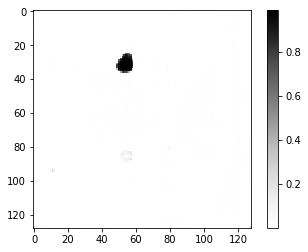

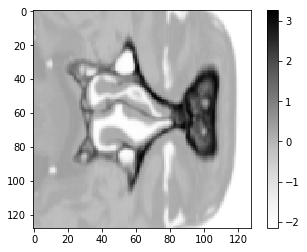

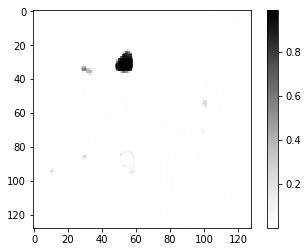

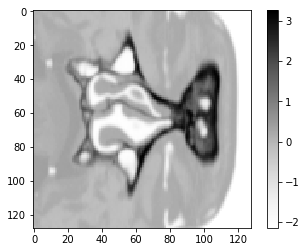

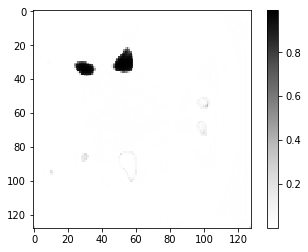

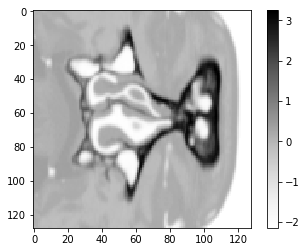

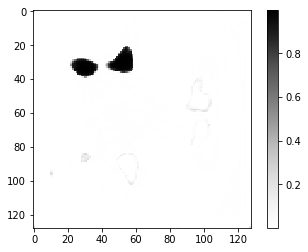

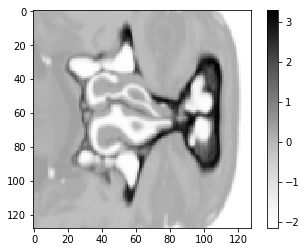

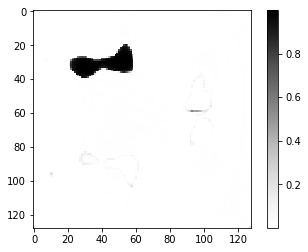

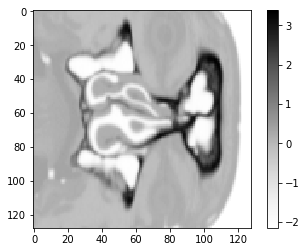

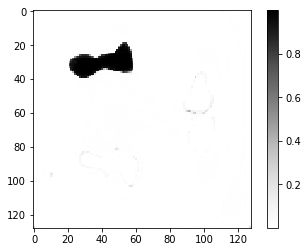

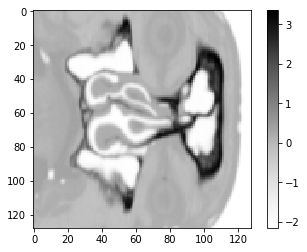

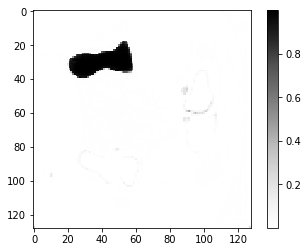

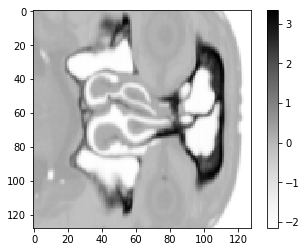

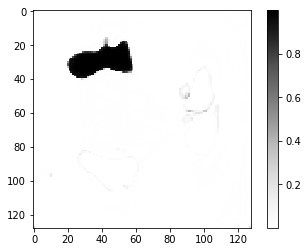

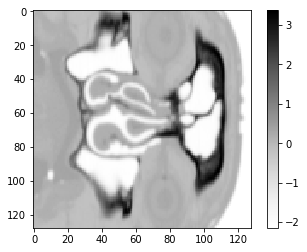

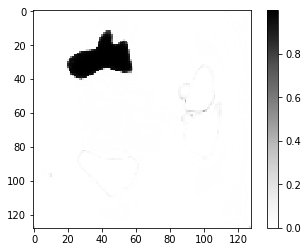

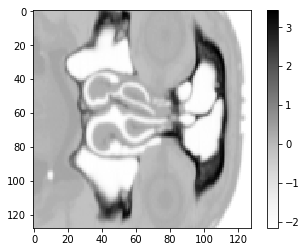

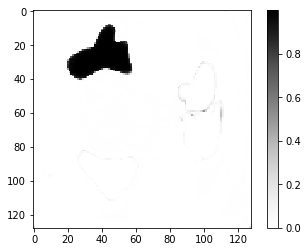

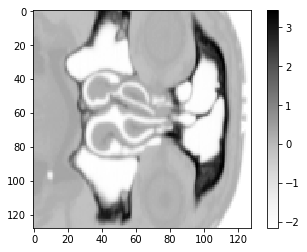

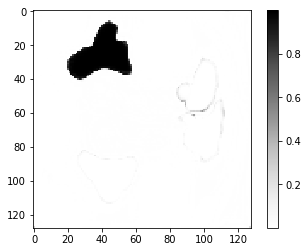

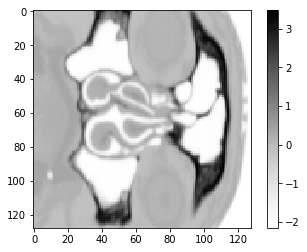

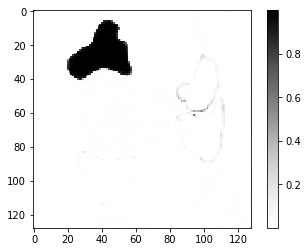

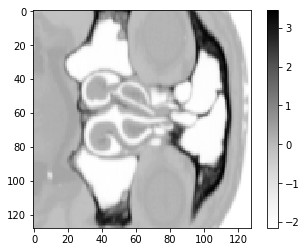

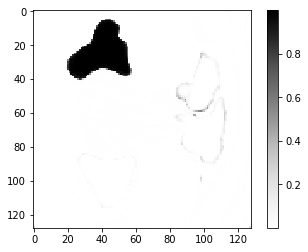

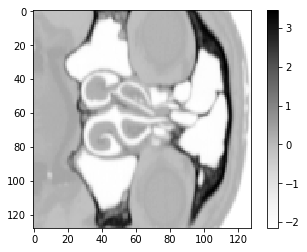

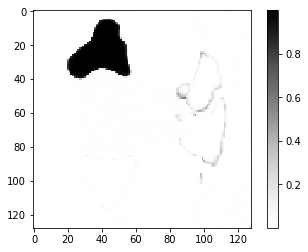

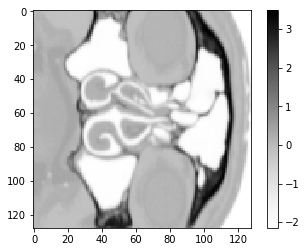

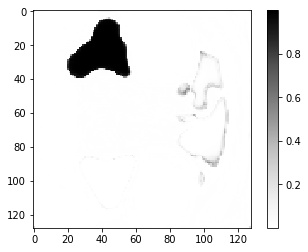

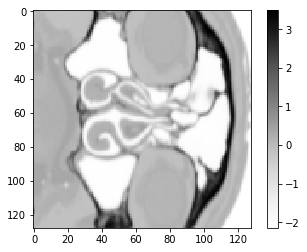

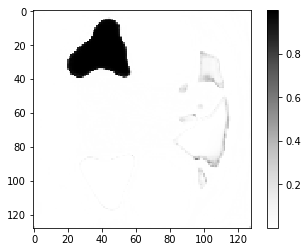

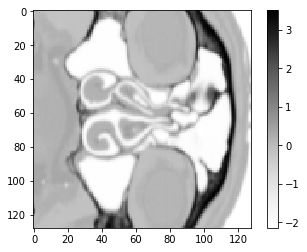

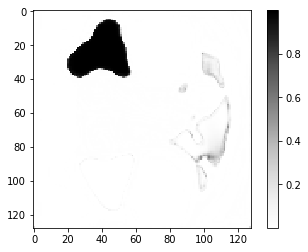

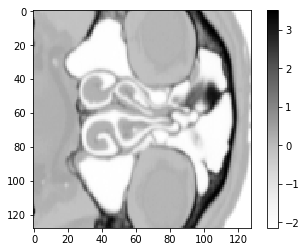

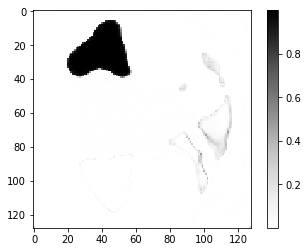

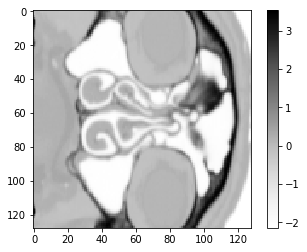

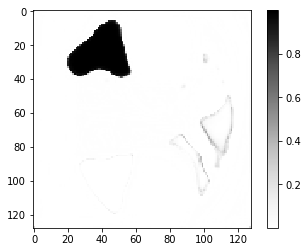

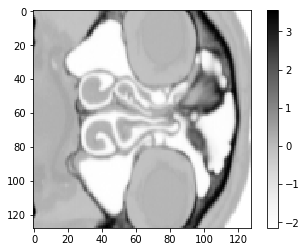

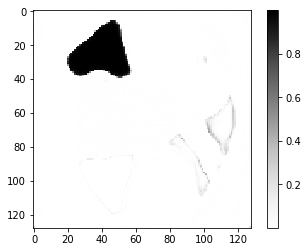

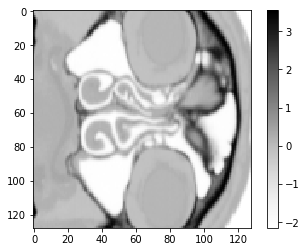

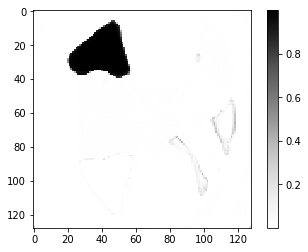

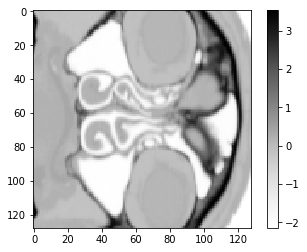

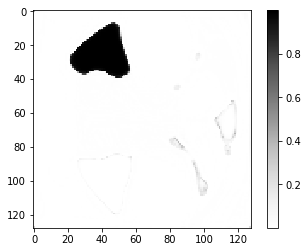

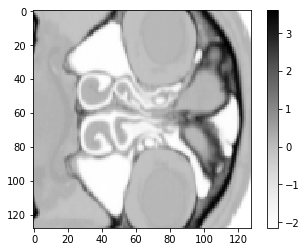

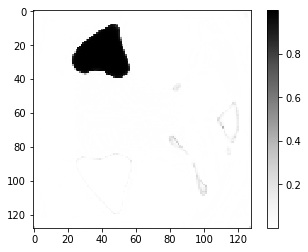

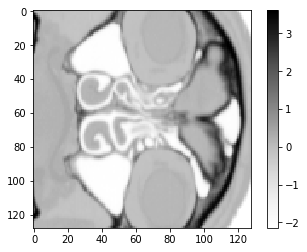

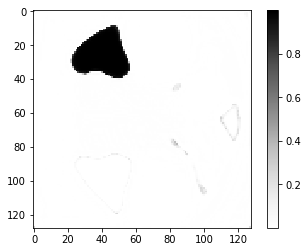

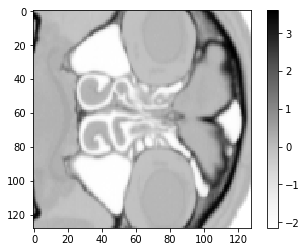

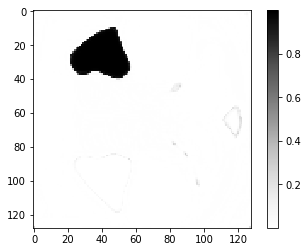

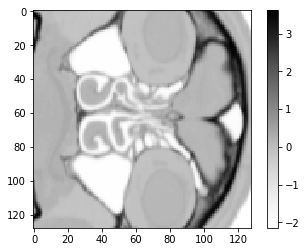

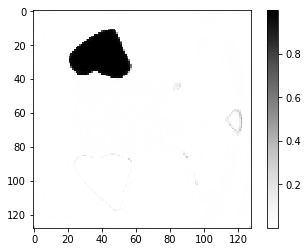

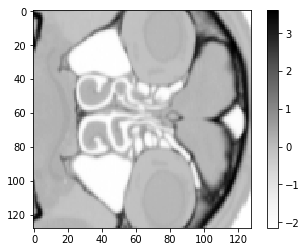

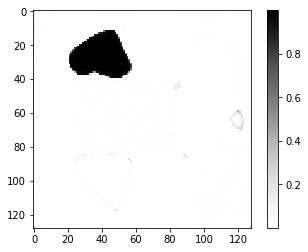

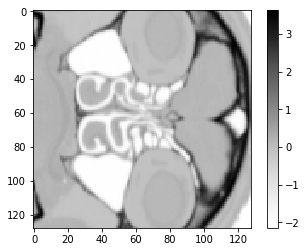

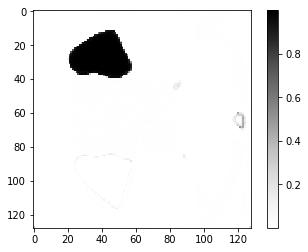

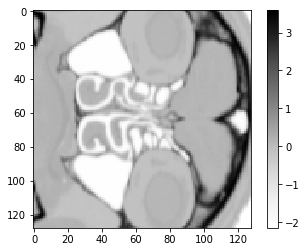

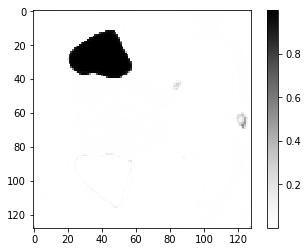

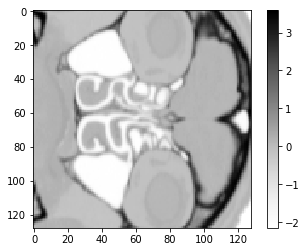

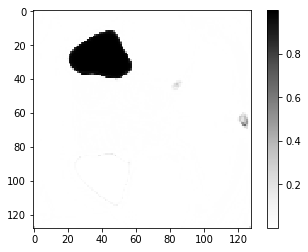

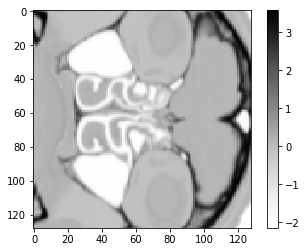

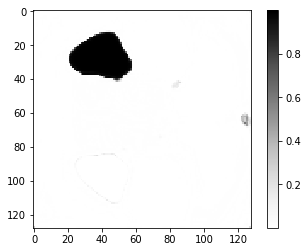

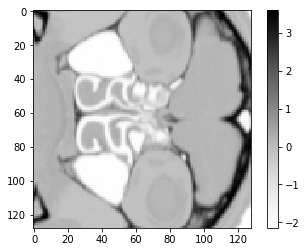

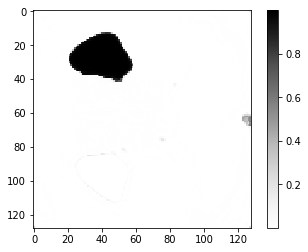

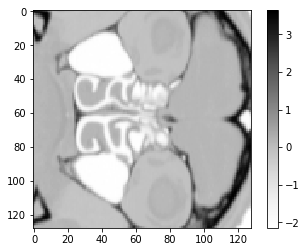

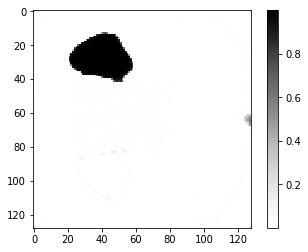

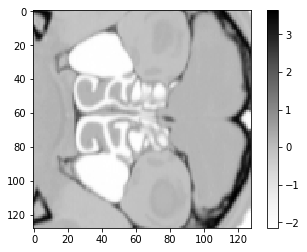

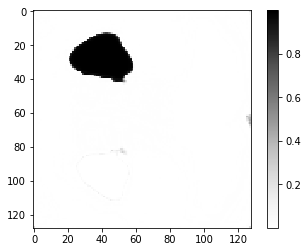

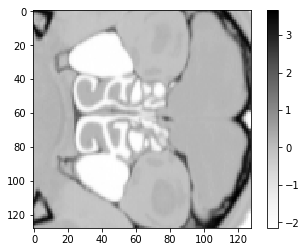

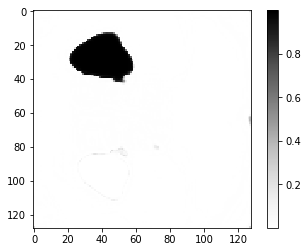

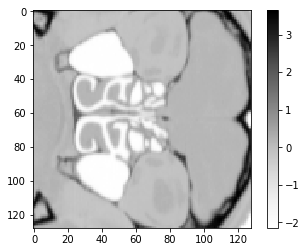

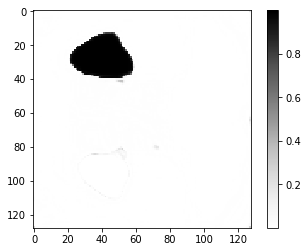

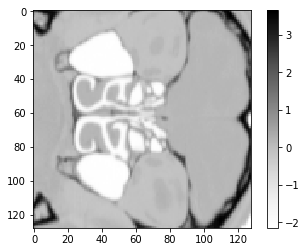

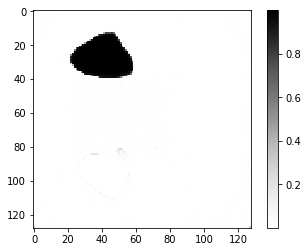

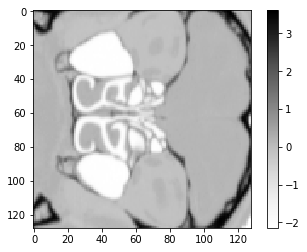

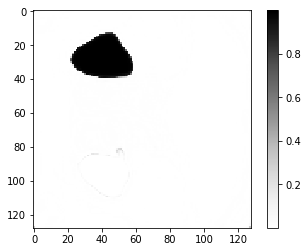

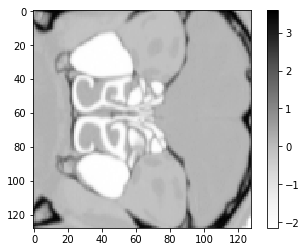

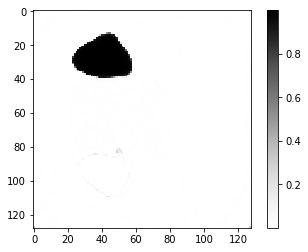

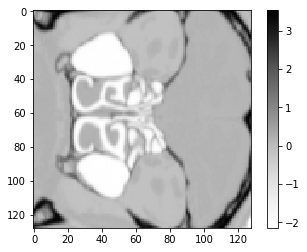

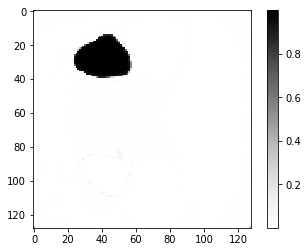

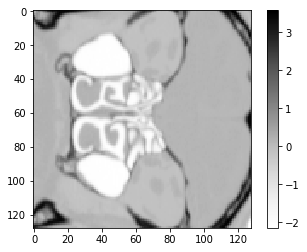

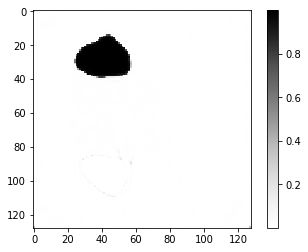

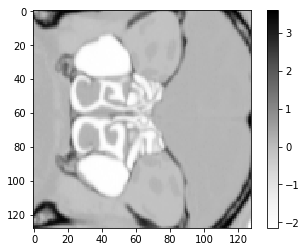

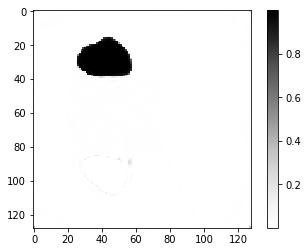

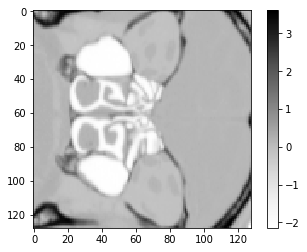

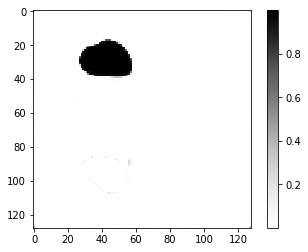

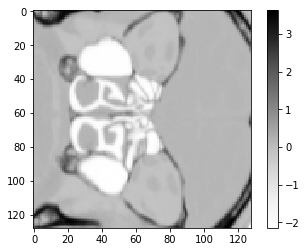

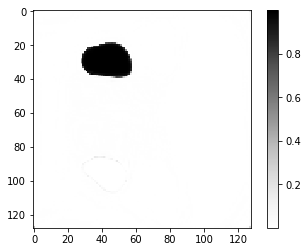

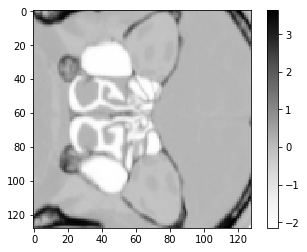

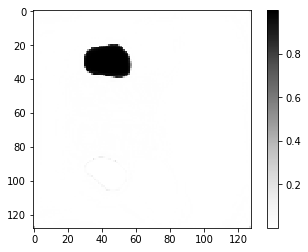

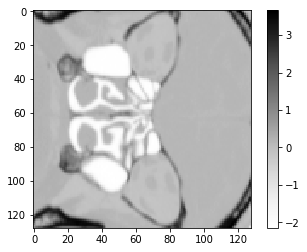

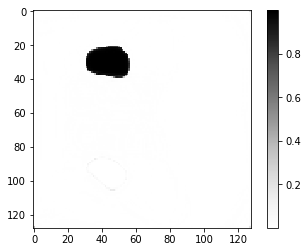

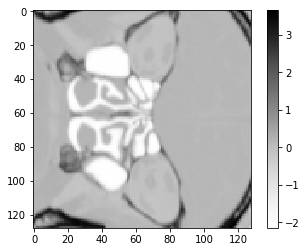

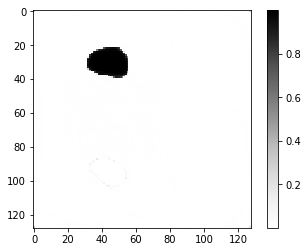

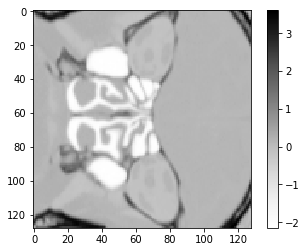

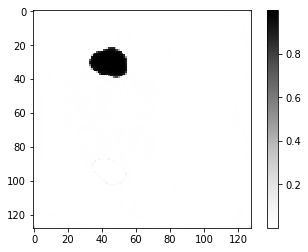

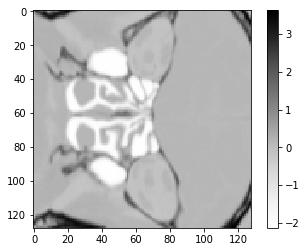

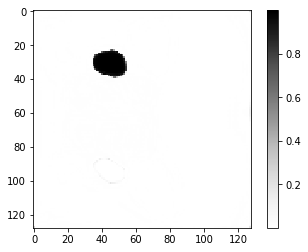

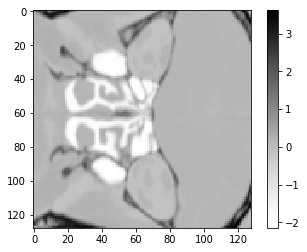

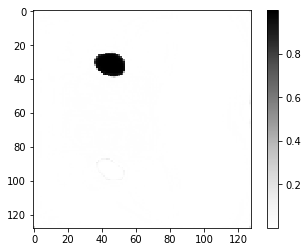

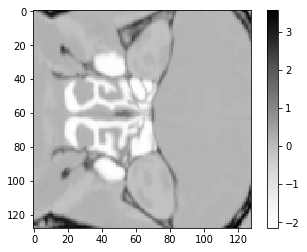

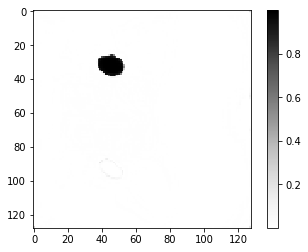

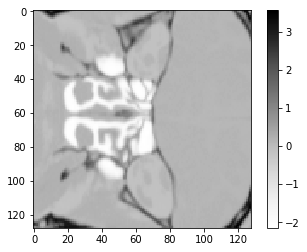

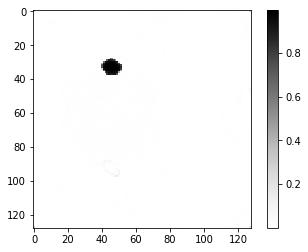

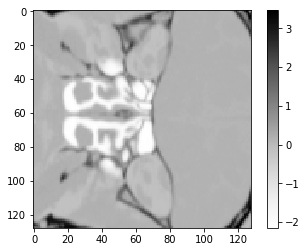

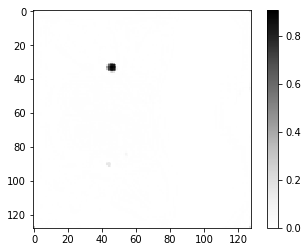

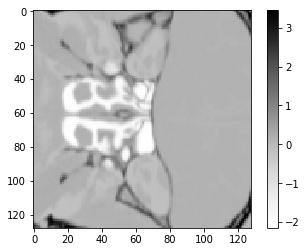

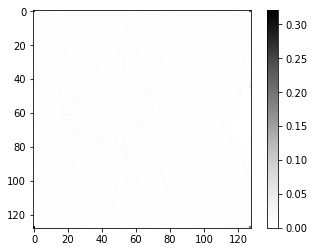

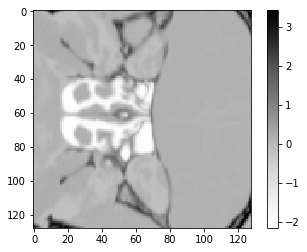

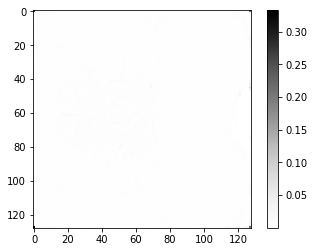

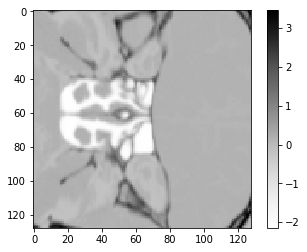

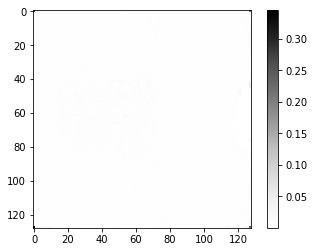

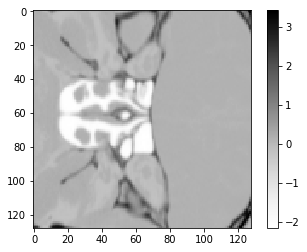

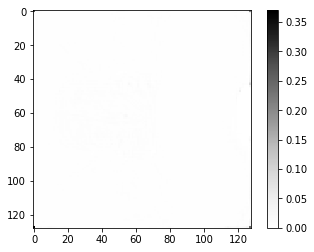

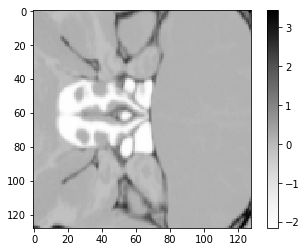

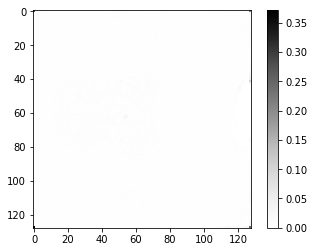

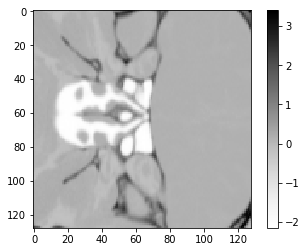

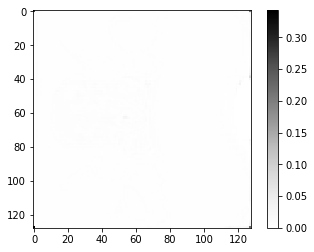

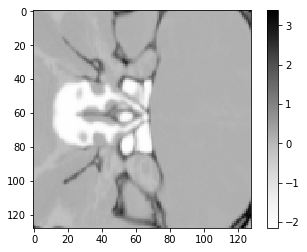

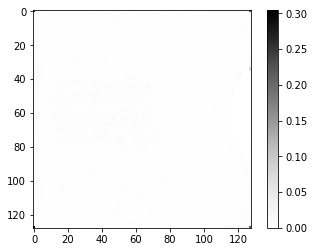

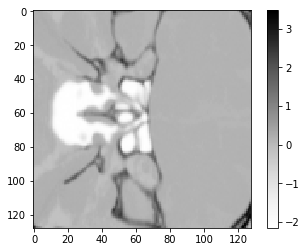

In [29]:
Xt = './data/X_train_CT_sinusTest_128.h5'
X_test = HDF5Matrix(Xt, 'DSt')
X_batch = np.transpose(X_test, (2,1,0))[70:]
X_batch = X_batch.reshape(X_batch.shape[0],1,img_rows,img_cols)
print (X_batch.shape)
mean = np.mean(X_batch)  # mean for data centering
std = np.std(X_batch)  # std for data normalization
X_batch -= mean
X_batch /= std
X_batch = X_batch.transpose((0,2,3,1))
YY1 = model.predict(X_batch, batch_size=1, verbose=0)
print(YY.shape)
count = 0
for yy in YY1:
    plt.imshow(yy[:,:,2].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    
    plt.imshow(X_batch[count,:,:].reshape(128,128),cmap = 'Greys')
    plt.colorbar()
    plt.show()
    count = count +1


Questions for Dr. Prince
1. Are there any recommended steps for pre-processing.
2. Are there any recommended steps for post-processing.
3. Are there any recommended steps for generating more training data.(I can think of applying some kind of linear distort.)
4. I wanted to train the volume(3D). But there are not enough data. Do you think I can generate fake data for training? Or is it necessary to do training in 3D. 
5. I only did maxillary and frontal. Because I am not sure about the location of ethmoid sinus. 
6. I guess this result can be the base line for further improvement, because they look good to me~ 

In [6]:
# Naive without post processing
def Merge(YY):
    result = np.zeros([128,128])
    for chann in range(5):
        mask = YY[:,:,chann] > 0.5
        result[mask] = chann
#         plt.imshow(result, cmap = 'Greys')
#         plt.show()
    return result

In [7]:
def MAP(YY):
    num_col = 128
    num_row = 128
    result = np.zeros([128,128])
    for i in range(num_row):
        for j in range(num_col):
            choices = YY[i,j,:]
            result[i,j] = np.argmax(choices)
    return result  

In [8]:
def Viterbi(YY):
    num_col = 128
    num_row = 128
    windowSize = 5
    result = np.zeros([128,128])
    for i in range(num_row):
        for j in range(num_col):
            choices = YY[i,j,:]
            result[i,j] = np.argmax(choices)
    return result  

(70, 128, 128, 5)


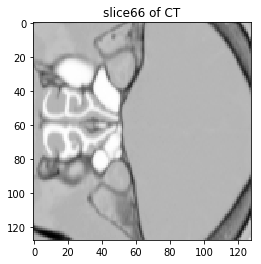

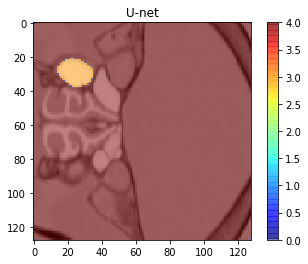

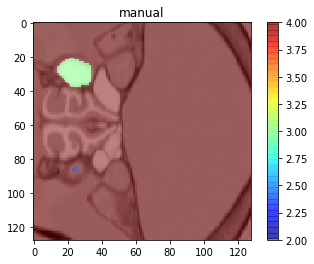

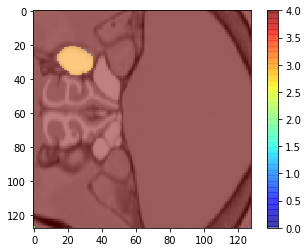

In [28]:
import cv2
print(YY.shape)
att = 66
background = np.flipud (X_batch[att,:,:].reshape(128,128))
overlay0 = np.flipud(Merge(YY[att]).reshape(128,128))
overlay1 = np.flipud(MAP(YY[att]).reshape(128,128))
manual = np.flipud(MAP(Y_train[att]).reshape(128,128))
plt.title('slice'+str(att)+ ' of CT')
plt.imshow(background, cmap = 'Greys')
plt.show()
plt.title('U-net')
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay0, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()

plt.title('manual')                  
plt.imshow(background, cmap = 'Greys')
plt.imshow(manual, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()

                   
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay1, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()


(70, 128, 128, 5)


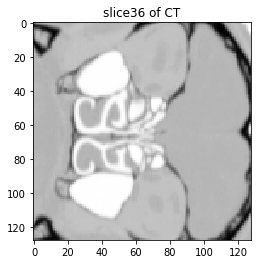

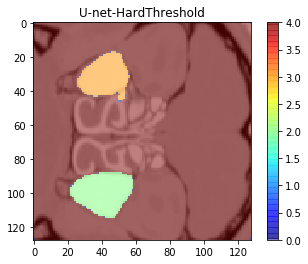

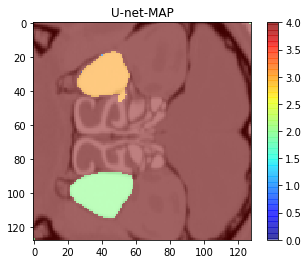

In [37]:
import cv2
print(YY.shape)
att = 36
background = np.flipud (X_batch[att,:,:].reshape(128,128))
overlay0 = np.flipud(Merge(YY1[att]).reshape(128,128))
overlay1 = np.flipud(MAP(YY1[att]).reshape(128,128))
# manual = np.flipud(MAP(Y_train[att]).reshape(128,128))
plt.title('slice'+str(att)+ ' of CT')
plt.imshow(background, cmap = 'Greys')
plt.show()
plt.title('U-net-HardThreshold')
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay0, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()

# plt.title('manual')                  
# plt.imshow(background, cmap = 'Greys')
# plt.imshow(manual, cmap = 'jet', alpha = 0.5)
# plt.colorbar()
# plt.show()

plt.title('U-net-MAP')                 
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay1, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()



# Possible Implementation of a regression Neural Network
(not yet implemented)

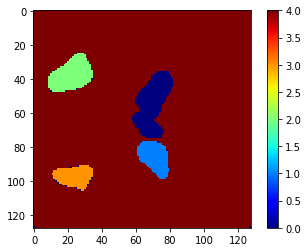

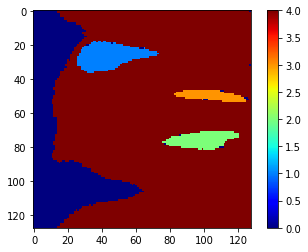

In [28]:
import cv2
roi = overlay0
center = (64,64)
radius = 64
plt.imshow(overlay0, cmap = 'jet')
plt.colorbar()
plt.show()
out = cv2.linearPolar(roi, center, radius, cv2.WARP_FILL_OUTLIERS)
plt.imshow(out,cmap = 'jet')
plt.colorbar()
plt.show()


In [103]:
from scipy import ndimage
lab = []
lab1 = YY[att][:,:,0]
lab2 = YY[att][:,:,1]
lab3 = YY[att][:,:,2]
lab4 = YY[att][:,:,3]
lab5 = YY[att][:,:,4]
cent1 = ndimage.measurements.center_of_mass(lab1)
cent2 = ndimage.measurements.center_of_mass(lab2)
cent3 = ndimage.measurements.center_of_mass(lab3)
cent4 = ndimage.measurements.center_of_mass(lab4)
cent5 = ndimage.measurements.center_of_mass(lab5)

centers = [cent1, cent2, cent3, cent4, cent5]

print (ndimage.measurements.center_of_mass(lab1))
print (ndimage.measurements.center_of_mass(lab2))
print (ndimage.measurements.center_of_mass(lab3))
print (ndimage.measurements.center_of_mass(lab4))
print (ndimage.measurements.center_of_mass(lab5))

(54.950191570881223, 69.5)
(78.480778318201644, 67.790765370653489)
(41.811956742685311, 29.170845927059027)
(88.601441047564279, 33.589107727709695)
(63.512240681459907, 64.917881621342531)


In [62]:
## COM
m = lab1
m = m / np.sum(np.sum(m))

dx = np.sum(m, 0) # there is a 0 here instead of the 1
dy = np.sum(m, 1) # as np.asarray switches the axes, because
                  # in matrices the vertical axis is the main
                  # one, while in images the horizontal one is
                  # the first
cx = np.sum(dx * np.arange(128))
cy = np.sum(dy * np.arange(128))
print (cx, cy)

68.727177443 56.5063653354


(30, 128, 128, 5)


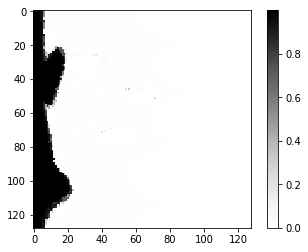

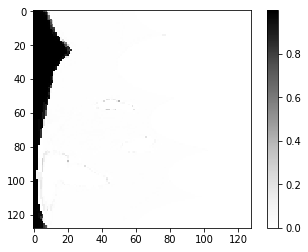

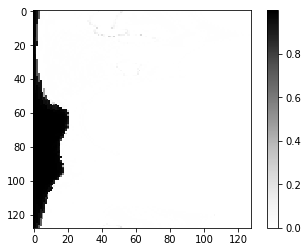

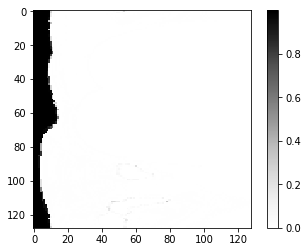

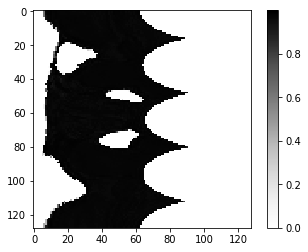

In [73]:
centers[3] = (95,25)
att = 14
radius = 128
print (YY.shape)
for i, cent in enumerate(centers):
    roi = YY[att][:,:,i]
    out = cv2.linearPolar(roi, (cent[1], cent[0]), radius, cv2.WARP_FILL_OUTLIERS)
    plt.imshow(out,cmap = 'Greys')
    plt.colorbar()
    plt.show()
    

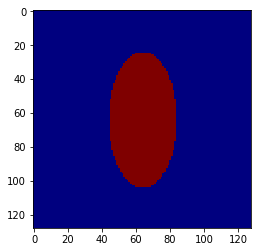

In [29]:
examp = np.zeros([128, 128])
for i in range(128):
    for j in range(128):
        if ((i-64)**2)/4 + (j-64)**2 < 400:
            examp[i,j] = 2
plt.imshow(examp,cmap = 'jet')
plt.show()

(128, 128)


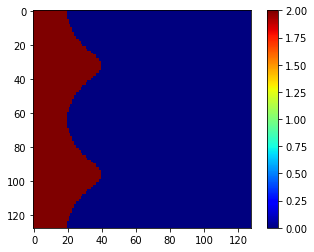

In [39]:
roi = examp
center = (64,64)
radius = 128

out = cv2.linearPolar(roi, center, radius, cv2.WARP_FILL_OUTLIERS)
plt.imshow(out,cmap = 'jet')
print (out.shape)
plt.colorbar()
plt.show()

In [58]:
np.sum(np.array([1,2,3,4]).reshape(2,-1),-1)

array([3, 7])

In [86]:
A = lab1
A = quantization(A, 0.7) 
B = A * (np.abs(ndimage.laplace(A)) > 0.5)

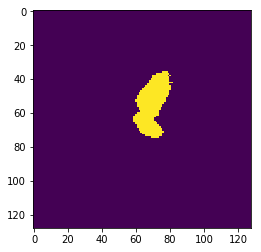

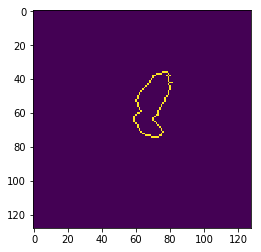

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


In [87]:
plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()
print (A == B)

# dilation erotion with all labels displayed at the end

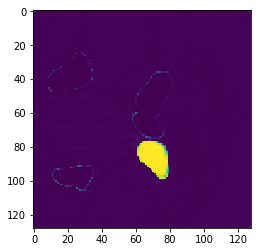

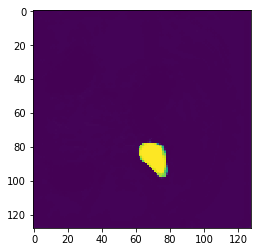

In [97]:
from skimage import morphology
tar = lab2
plt.imshow(tar)
plt.show()

C = skimage.morphology.erosion(tar, selem=None, out=None, shift_x=False, shift_y=False)
plt.imshow(C)
plt.show()

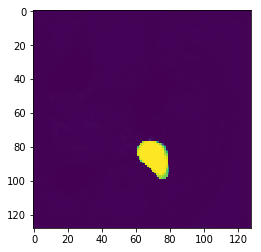

In [99]:
D = skimage.morphology.dilation(C, selem=None, out=None)
plt.imshow(D)
plt.show()

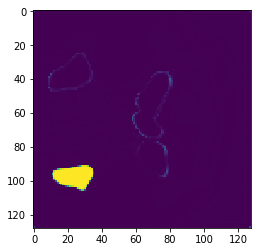

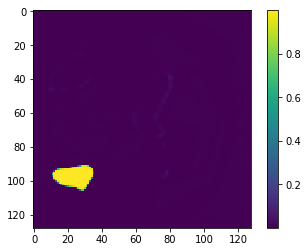

In [120]:
tar = lab4
plt.imshow(tar)
plt.show()

C = skimage.morphology.opening(tar)
plt.imshow(C)
plt.colorbar()
plt.show()

In [138]:
def OPENING(YY):
    out = np.zeros(YY.shape)
    for i in range(5):
        C = skimage.morphology.opening(YY[:,:,i])
#         C = skimage.morphology.opening(C)
#         C = skimage.morphology.opening(C)
#         C = skimage.morphology.opening(C)
#         C = skimage.morphology.opening(C)
        print(out.shape)
        out[:,:,i] = C
    
    return MAP(out)

In [ ]:
att = 13
background = X_batch[att,:,:].reshape(128,128)
overlay0 = Merge(YY[att]).reshape(128,128)
overlay1 = MAP(YY[att]).reshape(128,128)
overlay2 = OPENING(YY[att]).reshape(128,128)
plt.imshow(background, cmap = 'Greys')
plt.show()
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay0, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay1, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()
plt.imshow(background, cmap = 'Greys')
plt.imshow(overlay2, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show()

# TRY random walker for segmentation

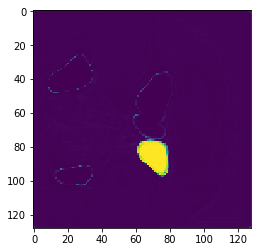

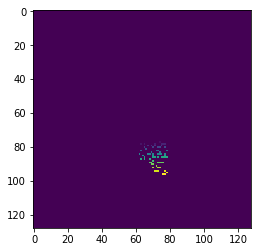

In [40]:
# add noise to the labels just for trial 
#example = YY[att][:,:,0]
example =  YY[att][:,:,1].copy()
plt.imshow(example)
plt.show()
noise = np.random.rand(example.shape[0],example.shape[1] ) > 0.8
mask = example > 0.5
example[~mask] = 0
example[mask] =  range(mask.sum()) #np.random.rand(mask.sum())
example[~noise] = 0
plt.imshow(example)
plt.show()

In [1]:
np.random.rand(2,2) > 0.8
labels = np.zeros([128,128])
labels[100, 80] = 1
labels[70,70] = 2

NameError: name 'np' is not defined

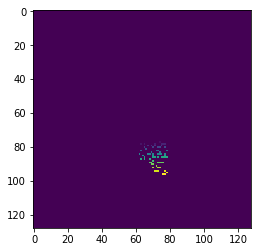

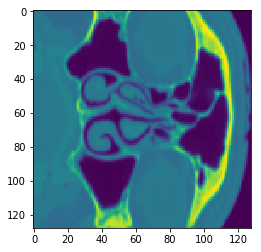

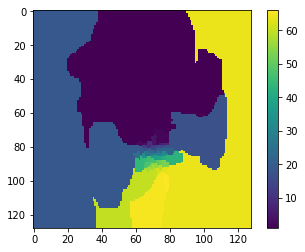

In [41]:
from skimage import segmentation
att = 13
data = X_batch[att,:,:].reshape(128,128)
labels = example
res = segmentation.random_walker(data, labels,beta=500)
plt.imshow(labels)
plt.show()
plt.imshow(data)
plt.show()
plt.imshow(res)
plt.colorbar()
plt.show()

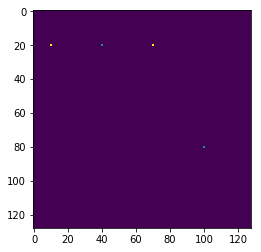

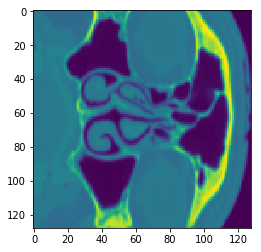

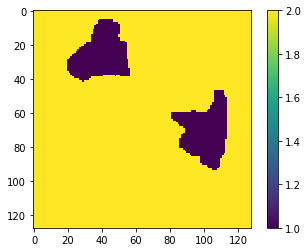

In [46]:
att = 13
data = X_batch[att,:,:].reshape(128,128)
labels = np.zeros(data.shape)
labels[80, 100] = 1.0
labels[20, 70] = 2.0
labels[20, 10] = 2.0
labels[20, 40] = 1.0
#labels[90, 50] = 1.0
# labels[81, 100] = 4.0
#labels[81, 99] = 5.0
res = segmentation.random_walker(data, labels,beta=130)
plt.imshow(labels)
plt.show()
plt.imshow(data)
plt.show()
plt.imshow(res)
plt.colorbar()
plt.show()


#  TRY region growing Algorithm

In [15]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Generate an initial image with two overlapping circles
# x, y = np.indices((80, 80))
# x1, y1, x2, y2 = 28, 28, 44, 52
# r1, r2 = 16, 20
# mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
# mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
# image = np.logical_or(mask_circle1, mask_circle2)
image = X_batch[att,:,:].reshape(128,128)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = morphology.label(local_maxi)
print('markers')
plt.imshow(markers)
plt.colorbar()
plt.show()
print('image')
plt.imshow(image)
plt.colorbar()
plt.show()
print('distance')
plt.imshow(-distance)
plt.colorbar()
plt.show()

labels_ws = watershed(-distance, markers, mask=image)
plt.imshow(labels_ws)
plt.show()

NameError: name 'morphology' is not defined

traditional region grow algorithm.

In [1]:
import cv2
import numpy as np

def get8n(x, y, shape):
    out = []
    maxx = shape[1]-1
    maxy = shape[0]-1

    #top left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #top right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))

    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))

    #bottom left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))

    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))

    #bottom right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    return out

def region_growing(img, seed):
    list = []
    outimg = np.zeros_like(img)
    list.append((seed[0], seed[1]))
    processed = []
    while(len(list) > 0):
        pix = list[0]
        outimg[pix[0], pix[1]] = 255
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                outimg[coord[0], coord[1]] = 255
                if not coord in processed:
                    list.append(coord)
                processed.append(coord)
        list.pop(0)
        #cv2.imshow("progress",outimg)
        #cv2.waitKey(1)
    return outimg

def on_mouse(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print ('Seed:' + str(x) + ', ' + str(y), img[y,x])
        clicks.append((y,x))

clicks = []
image = X_batch[att,:,:].reshape(128,128)
ret, img = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
cv2.namedWindow('Input')
cv2.setMouseCallback('Input', on_mouse, 0, )
cv2.imshow('Input', img)
cv2.waitKey()
seed = clicks[-1]
out = region_growing(img, seed)
cv2.imshow('Region Growing', out)
cv2.waitKey()
cv2.destroyAllWindows()

NameError: name 'X_batch' is not defined